In [1]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

In [5]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [32]:
ex = 'European Union fined Google a record $5.1 billion on Wednesday for abusing its power in the mobile phone market and ordered the company to alter its practices, said Junker'

ner = nltk.word_tokenize(ex)
ner = nltk.pos_tag(ner)

print(ner)

[('European', 'NNP'), ('Union', 'NNP'), ('fined', 'VBD'), ('Google', 'NNP'), ('a', 'DT'), ('record', 'NN'), ('$', '$'), ('5.1', 'CD'), ('billion', 'CD'), ('on', 'IN'), ('Wednesday', 'NNP'), ('for', 'IN'), ('abusing', 'VBG'), ('its', 'PRP$'), ('power', 'NN'), ('in', 'IN'), ('the', 'DT'), ('mobile', 'JJ'), ('phone', 'NN'), ('market', 'NN'), ('and', 'CC'), ('ordered', 'VBD'), ('the', 'DT'), ('company', 'NN'), ('to', 'TO'), ('alter', 'VB'), ('its', 'PRP$'), ('practices', 'NNS'), (',', ','), ('said', 'VBD'), ('Junker', 'NNP')]


We get a list of tuples containing the individual words in the sentence and their associated part-of-speech.
Now we’ll implement noun phrase chunking to identify named entities using a regular expression consisting of rules that indicate how sentences should be chunked.

Our chunk pattern consists of one rule, that a noun phrase, NP, should be formed whenever the chunker finds an optional determiner, DT, followed by any number of adjectives, JJ, and then a noun, NN.

In [21]:
pattern = 'NP: {<DT>?<JJ>*<NN>}'

cp = nltk.RegexpParser(pattern)
cs = cp.parse(ner)
print(cs)

(S
  EU/NNP
  fined/VBD
  Google/NNP
  (NP a/DT record/NN)
  $/$
  5.1/CD
  billion/CD
  on/IN
  Wednesday/NNP
  for/IN
  abusing/VBG
  its/PRP$
  (NP power/NN)
  in/IN
  (NP the/DT mobile/JJ phone/NN)
  (NP market/NN)
  and/CC
  ordered/VBD
  (NP the/DT company/NN)
  to/TO
  alter/VB
  its/PRP$
  practices/NNS
  ,/,
  said/VBD
  Junker/NNP)


With the function nltk.ne_chunk(), we can recognize named entities using a classifier, the classifier adds category labels such as PERSON, ORGANIZATION, and GPE.

In [22]:
nltk.download('words')
nltk.download('maxent_ne_chunker')

ne_tree = nltk.ne_chunk(pos_tag(word_tokenize(ex)))
print(ne_tree)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
(S
  (GPE EU/NNP)
  fined/VBD
  (PERSON Google/NNP)
  a/DT
  record/NN
  $/$
  5.1/CD
  billion/CD
  on/IN
  Wednesday/NNP
  for/IN
  abusing/VBG
  its/PRP$
  power/NN
  in/IN
  the/DT
  mobile/JJ
  phone/NN
  market/NN
  and/CC
  ordered/VBD
  the/DT
  company/NN
  to/TO
  alter/VB
  its/PRP$
  practices/NNS
  ,/,
  said/VBD
  (PERSON Junker/NNP))


In [23]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

# SpaCy

SpaCy’s named entity recognition has been trained on the OntoNotes 5 corpus and it supports the following entity types:

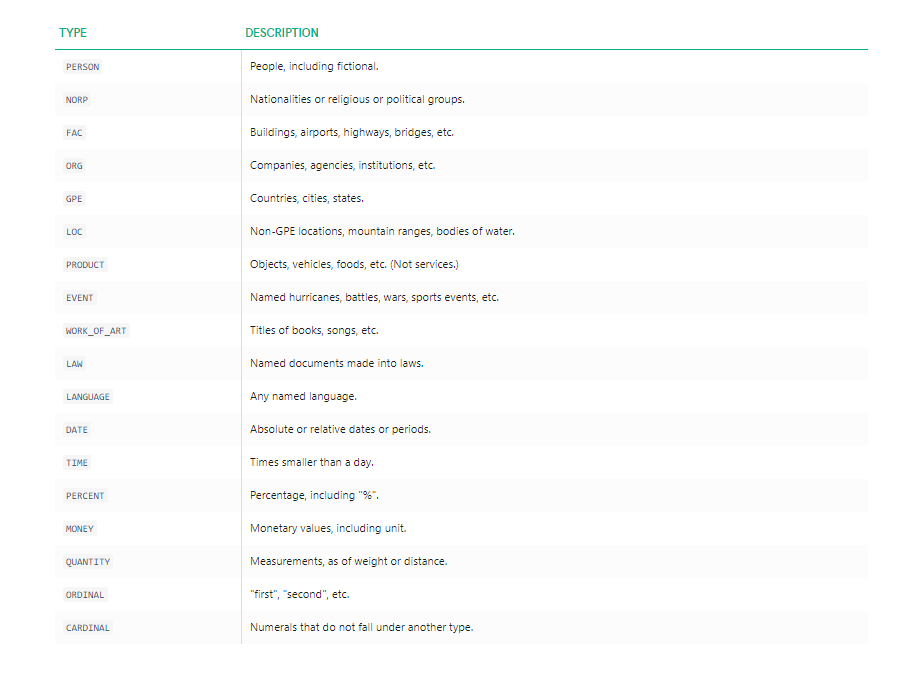

In [33]:
doc = nlp('European Union fined Google a record $5.1 billion on Wednesday for abusing its power in the mobile phone market and ordered the company to alter its practices, said Junker')
pprint([(X.text, X.label_) for X in doc.ents])

[('European Union', 'ORG'),
 ('Google', 'ORG'),
 ('$5.1 billion', 'MONEY'),
 ('Wednesday', 'DATE')]


European Union is ORG , Google is an organization, $5.1 billion is monetary value and Wednesday is a date object. They are all correct.

## Token
During the above example, we were working on entity level, in the following example, we are demonstrating token-level entity annotation using the BILUO tagging scheme to describe the entity boundaries.

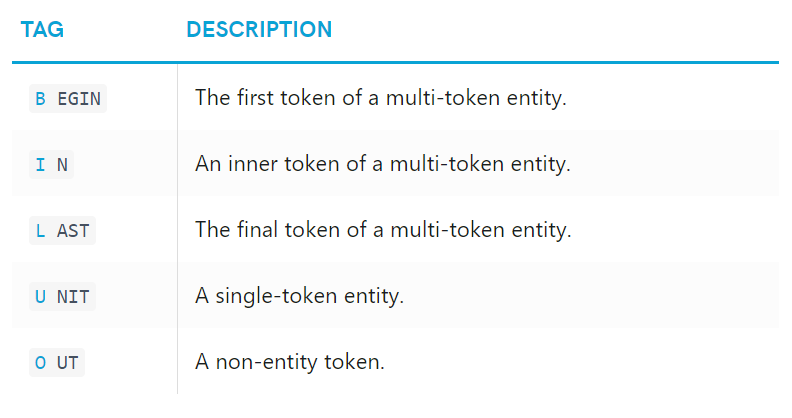

In [34]:
pprint([(X, X.ent_iob_, X.ent_type_) for X in doc])

[(European, 'B', 'ORG'),
 (Union, 'I', 'ORG'),
 (fined, 'O', ''),
 (Google, 'B', 'ORG'),
 (a, 'O', ''),
 (record, 'O', ''),
 ($, 'B', 'MONEY'),
 (5.1, 'I', 'MONEY'),
 (billion, 'I', 'MONEY'),
 (on, 'O', ''),
 (Wednesday, 'B', 'DATE'),
 (for, 'O', ''),
 (abusing, 'O', ''),
 (its, 'O', ''),
 (power, 'O', ''),
 (in, 'O', ''),
 (the, 'O', ''),
 (mobile, 'O', ''),
 (phone, 'O', ''),
 (market, 'O', ''),
 (and, 'O', ''),
 (ordered, 'O', ''),
 (the, 'O', ''),
 (company, 'O', ''),
 (to, 'O', ''),
 (alter, 'O', ''),
 (its, 'O', ''),
 (practices, 'O', ''),
 (,, 'O', ''),
 (said, 'O', ''),
 (Junker, 'O', '')]


# Extracting named entity from an article

Now let’s get serious with SpaCy and extracting named entities from a New York Times article, — “F.B.I. Agent Peter Strzok, Who Criticized Trump in Texts, Is Fired.”

In [35]:
from bs4 import BeautifulSoup
import requests
import re
def url_to_string(url):
    res = requests.get(url)
    html = res.text
    soup = BeautifulSoup(html, 'html5lib')
    for script in soup(["script", "style", 'aside']):
        script.extract()
    return " ".join(re.split(r'[\n\t]+', soup.get_text()))
ny_bb = url_to_string('https://www.nytimes.com/2018/08/13/us/politics/peter-strzok-fired-fbi.html?hp&action=click&pgtype=Homepage&clickSource=story-heading&module=first-column-region&region=top-news&WT.nav=top-news')
article = nlp(ny_bb)
len(article.ents)

154

Ok, it seems there are 154 entities recognized!

In [37]:
labels = [x.label_ for x in article.ents]
Counter(labels)

Counter({'CARDINAL': 3,
         'DATE': 23,
         'GPE': 9,
         'LOC': 1,
         'NORP': 2,
         'ORDINAL': 1,
         'ORG': 38,
         'PERSON': 77})

Let’s run displacy.render to generate the raw markup.

Here are the top 3:

In [40]:
items = [x.text for x in article.ents]
Counter(items).most_common(3)

[('Strzok', 29), ('F.B.I.', 19), ('Trump', 13)]

Some fancy highlighting of the sentence:

In [39]:
sentences = [x for x in article.sents]
displacy.render(nlp(str(sentences[20])), jupyter=True, style='ent')

Credits go to https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da